# Simple LSTM for Time Series Prediction
From Usman Malik's [Time Series Prediction using LSTM with PyTorch in Python](https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/).

In [21]:
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
# Checking datasets in seaborn
sns.get_dataset_names()

['anagrams',
 'anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'exercise',
 'flights',
 'fmri',
 'gammas',
 'geyser',
 'iris',
 'mpg',
 'penguins',
 'planets',
 'tips',
 'titanic']

In [23]:
# Checking structure of flight data
flight_data = sns.load_dataset("flights")
flight_data.head()

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


In [24]:
# Checcking size of flight data
flight_data.shape

(144, 3)

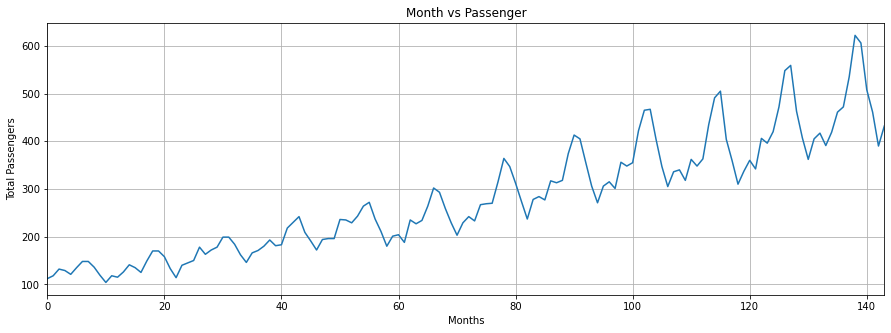

In [25]:
# Plotting passengers per month
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.xlabel('Months')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(flight_data['passengers'])
plt.show()

In [26]:
# Checking columns of flight data
flight_data.columns

Index(['year', 'month', 'passengers'], dtype='object')

In [27]:
# Convert passengers to float array
all_data = flight_data['passengers'].values.astype(float)

In [28]:
# Train-test split
test_data_size = 24

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

print('Size of train dataset: %d' % (len(train_data)))
print('Size of test dataset: %d' % (len(test_data)))

Size of train dataset: 120
Size of test dataset: 24


It is very important to normalize the data for time series predictions. We will perform min/max scaling on the dataset which normalizes the data within a certain range of minimum and maximum values. We will be using the MinMaxScaler class from the sklearn.preprocessing module to scale our data.

It is important to mention here that data normalization is only applied on the training data and not on the test data. If normalization is applied on the test data, there is a chance that some information will be leaked from training set into the test set.

In [29]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

In [30]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [31]:
train_data_normalized

tensor([-0.9601, -0.9302, -0.8603, -0.8753, -0.9152, -0.8454, -0.7805, -0.7805,
        -0.8404, -0.9252, -1.0000, -0.9302, -0.9451, -0.8903, -0.8155, -0.8454,
        -0.8953, -0.7756, -0.6708, -0.6708, -0.7307, -0.8554, -0.9501, -0.8204,
        -0.7955, -0.7706, -0.6309, -0.7057, -0.6608, -0.6309, -0.5262, -0.5262,
        -0.6010, -0.7107, -0.7905, -0.6908, -0.6658, -0.6209, -0.5561, -0.6160,
        -0.6060, -0.4314, -0.3716, -0.3117, -0.4763, -0.5661, -0.6608, -0.5511,
        -0.5411, -0.5411, -0.3416, -0.3466, -0.3766, -0.3067, -0.2020, -0.1621,
        -0.3367, -0.4663, -0.6209, -0.5162, -0.5012, -0.5810, -0.3466, -0.3865,
        -0.3516, -0.2020, -0.0125, -0.0574, -0.2269, -0.3766, -0.5062, -0.3766,
        -0.3117, -0.3566, -0.1870, -0.1771, -0.1721,  0.0524,  0.2968,  0.2120,
         0.0374, -0.1521, -0.3367, -0.1322, -0.1022, -0.1372,  0.0623,  0.0424,
         0.0673,  0.3466,  0.5411,  0.5012,  0.2519,  0.0075, -0.1671,  0.0075,
         0.0524, -0.0175,  0.2569,  0.21

You can use any sequence length and it depends upon the domain knowledge. However, in our dataset it is convenient to use a sequence length of 24 since we have monthly data and there are 12 months in a year, but we need two years to capture the trend. If we had daily data, a better sequence length would have been 365, i.e. the number of days in a year. Therefore, we will set the input sequence length for training to 24.

In [32]:
train_window = 24
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
train_inout_seq[:3]

[(tensor([-0.9601, -0.9302, -0.8603, -0.8753, -0.9152, -0.8454, -0.7805, -0.7805,
          -0.8404, -0.9252, -1.0000, -0.9302, -0.9451, -0.8903, -0.8155, -0.8454,
          -0.8953, -0.7756, -0.6708, -0.6708, -0.7307, -0.8554, -0.9501, -0.8204]),
  tensor([-0.7955])),
 (tensor([-0.9302, -0.8603, -0.8753, -0.9152, -0.8454, -0.7805, -0.7805, -0.8404,
          -0.9252, -1.0000, -0.9302, -0.9451, -0.8903, -0.8155, -0.8454, -0.8953,
          -0.7756, -0.6708, -0.6708, -0.7307, -0.8554, -0.9501, -0.8204, -0.7955]),
  tensor([-0.7706])),
 (tensor([-0.8603, -0.8753, -0.9152, -0.8454, -0.7805, -0.7805, -0.8404, -0.9252,
          -1.0000, -0.9302, -0.9451, -0.8903, -0.8155, -0.8454, -0.8953, -0.7756,
          -0.6708, -0.6708, -0.7307, -0.8554, -0.9501, -0.8204, -0.7955, -0.7706]),
  tensor([-0.6309]))]

## Creating the LSTM module
The constructor of the LSTM class accepts three parameters:

- ```input_size```: Corresponds to the number of features in the input. Though our sequence length is 12, for each month we have only 1 value i.e. total number of passengers, therefore the input size will be 1.
- ```hidden_layer_size```: The number of neurons in each layer. Our tuple has value 100, therefore we will have layers of 100 neurons.
- ```output_size```: The number of items in the output, since we want to predict the number of passengers for 1 month in the future, the output size will be 1.
- ```num_lstm_layers```: The number of LSTM recurrent layers.

Next, in the constructor we create variables ```hidden_layer_size```, ```lstm```, ```linear``` and ```hidden_cell```. LSTM algorithm accepts three inputs: previous hidden state, previous cell state and current input. The ```hidden_cell``` variable contains the previous hidden and cell state. The ```lstm``` and ```linear``` layer variables are used to create the LSTM and linear layers.

Inside the ```forward``` method, the ```input_seq``` is passed as a parameter, which is first passed through the ```lstm``` layer. The output of the ```lstm ```layer is the hidden and cell states at current time step, along with the output. The output from the ```lstm``` layer is passed to the ```linear``` layer. The predicted number of passengers is stored in the last item of the ```predictions``` list, which is returned to the calling function.

The next step is to create an object of the ```LSTM()``` class, define a loss function and the optimizer. Since, we are solving a regression problem, we will use the MSE loss. For the optimizer function, we will use the adam optimizer.

## Glossary
- ```hidden_cell```: a tuple containing a vector for ```h_0``` (hidden state) and ```c_0``` (cell state)
- ```c_0```: cell state, the long term memory
- ```h_0```: hidden state, the short term (working) memory


In [33]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1, num_lstm_layers=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_lstm_layers)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(num_lstm_layers,1,self.hidden_layer_size),
                            torch.zeros(num_lstm_layers,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [34]:
# Building the model
num_lstm_layers=2
model = LSTM(hidden_layer_size=32, num_lstm_layers=num_lstm_layers)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)
print(model)

LSTM(
  (lstm): LSTM(1, 32, num_layers=2)
  (linear): Linear(in_features=32, out_features=1, bias=True)
)


In [35]:
# Training and printing
epochs = 150

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(num_lstm_layers, 1, model.hidden_layer_size),
                        torch.zeros(num_lstm_layers, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.01842494
epoch:  26 loss: 0.00424922
epoch:  51 loss: 0.00284876
epoch:  76 loss: 0.00052152
epoch: 101 loss: 0.00008005
epoch: 126 loss: 0.00006111
epoch: 149 loss: 0.0032648528


In [36]:
fut_pred = 24

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[0.05236907675862312, -0.017456358298659325, 0.25685784220695496, 0.21695759892463684, 0.251870334148407, 0.586034893989563, 0.8004987239837646, 0.8104737997055054, 0.4962593615055084, 0.21197007596492767, 0.0024937656708061695, 0.15710723400115967, 0.17705735564231873, 0.06733167171478271, 0.28678303956985474, 0.21695759892463684, 0.2917705774307251, 0.6508728265762329, 0.9301745891571045, 1.0, 0.4962593615055084, 0.27182045578956604, 0.027431420981884003, 0.16209475696086884]


Initially the ```test_inputs``` item will contain 24 items. Inside a ```for``` loop these 24 items will be used to make predictions about the first item from the test set i.e. the item number 133. The predict value will then be appended to the ```test_inputs``` list. During the second iteration, again the last 24 items will be used as input and a new prediction will be made which will then be appended to the ```test_inputs``` list again. The ```for``` loop will execute for 24 times since there are 24 elements in the test set. At the end of the loop the ```test_inputs``` list will contain 48 items. The last 24 items will be the predicted values for the test set.

### Performance Degradation
The test methodology assumes no knowledge of any test value. Initially, the time-span between the last certain datapoint and the prediction will be 1 month, but this window will expand as we move forward. As a result, we would expect divergence in performance for the last datapoints of the training set.

In [37]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        # model.hidden = (torch.zeros(num_lstm_layers, 1, model.hidden_layer_size),
        #                 torch.zeros(num_lstm_layers, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

test_inputs[fut_pred:]

[0.20488771796226501,
 0.15315645933151245,
 0.21698427200317383,
 0.2926671802997589,
 0.41079196333885193,
 0.7688536643981934,
 1.044932246208191,
 1.005837321281433,
 0.6590290069580078,
 0.36515164375305176,
 0.14531633257865906,
 0.11759623140096664,
 0.20777490735054016,
 0.14313378930091858,
 0.1956668198108673,
 0.2758313715457916,
 0.3447423577308655,
 0.5808913111686707,
 0.9667493104934692,
 1.074713110923767,
 0.8410823345184326,
 0.4804075062274933,
 0.2577066719532013,
 0.04746570438146591]

In [38]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

[[345.57998745]
 [335.2078701 ]
 [348.00534654]
 [363.17976965]
 [386.86378865]
 [458.65515971]
 [514.00891536]
 [506.17038292]
 [436.6353159 ]
 [377.71290457]
 [333.63592468]
 [328.0780444 ]
 [346.15886892]
 [333.19832475]
 [343.73119737]
 [359.80418999]
 [373.62084273]
 [420.96870789]
 [498.33323675]
 [519.97997874]
 [473.13700807]
 [400.821705  ]
 [356.17018773]
 [314.01687373]]


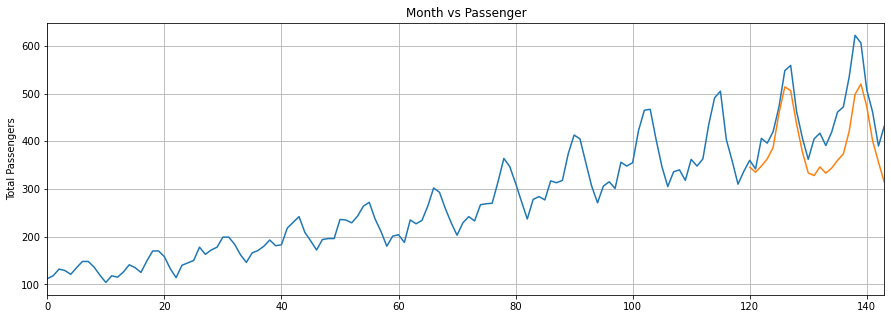

In [39]:
x = np.arange(144-train_window, 144, 1)
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'])
plt.plot(x,actual_predictions)
plt.show()

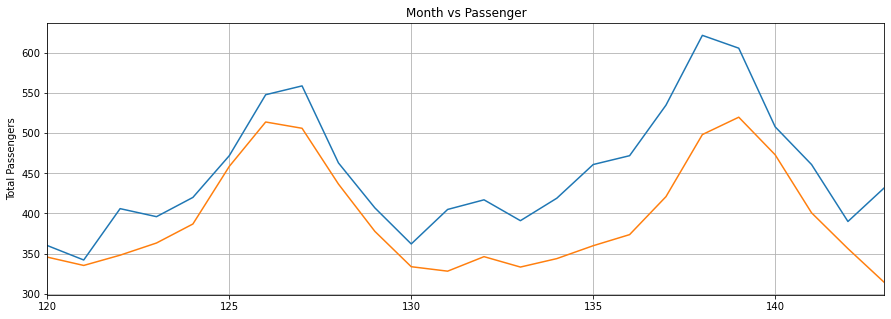

In [40]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(flight_data['passengers'][-train_window:])
plt.plot(x,actual_predictions)
plt.show()